In [1]:
from einops import rearrange
import copy
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import torch
torch.cuda.set_device(1)
from pdb import set_trace
import matplotlib.pyplot as plt
from torch import nn
from x_transformers import  Encoder, Decoder
from x_transformers.autoregressive_wrapper import exists
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from fastai.vision.all import BCEWithLogitsLossFlat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
import os
from timm import create_model
import random
from tqdm import tqdm

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torch import Tensor
import torch.nn.functional as F
from typing import Tuple
import pickle

In [27]:
class CFG:
    bs = 32
    nw = 4
    model_name = "convmixer_1536_20"
    lr = 1e-4
    wd = 1e-4
    epoch = 12
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_200_BASELINE_CASHE_V3"
    mixup=False
    exp_name = f"{folder}_{model_name}"

In [28]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df):
    val_df_eval = df.copy()

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])

    roc_25_50 = roc_auc_score(
        get_snr(30, 50, val_df_eval)["target"], get_snr(30, 50, val_df_eval)["pred"]
    )

    return {
        "roc_all": roc_100,
        "roc_30_50": roc_25_50,

    }



In [29]:
def time_mask(spec, T=10):
    cloned = spec.clone().detach()
    len_spectro = cloned.shape[2]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        cloned[:, :,t_zero:mask_end] = 0
    return cloned




def freq_mask(spec, F=30):
    cloned = spec.clone().detach()
    num_mel_channels = cloned.shape[1]
    num_masks = np.random.randint(3, 8)
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        cloned[:, f_zero:mask_end, :] = 0
    
    return cloned

In [30]:
def read_pkl(filename):   
    with open(filename, 'rb') as file1: 
        k = pickle.load(file1)
        h1 = k["H1"]['spectrogram']
        l1 = k["L1"]['spectrogram']
        h1_timestamp = k["H1"]['timestamps']
        l1_timestamp = k["L1"]['timestamps']
        freq = k['frequency']
        
    data_dict = {"sft" : np.stack([h1[:, :4096], l1[:, :4096]]), 
                 "timestamps": {"H1": h1_timestamp, 
                                    "L1": l1_timestamp}}
    return data_dict

In [31]:
def preprocess(sft):
    sft = sft * 1e22
    sft = sft.real**2 + sft.imag**2
    return sft


def normalize(data):
    data[0] = data[0] / data[0].mean()
    data[1] = data[1] / data[1].mean()
    data = data.reshape(2, 360, 128, 32).mean(-1)  # compress 4096 -> 128
    data = data - data.mean()
    data = data / data.std()
    return torch.tensor(data)


def read_h5(file):
    file = Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        k = f[filename]
        h1 = k["H1"]
        l1 = k["L1"]
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        data_dict = {"sft" : np.stack([h1_stft[:, :4096], l1_stft[:, :4096]]), 
                 "timestamps": {"H1": h1_timestamp, 
                                    "L1": l1_timestamp}}
        
        return data_dict
    

    
class ValLoader(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(preprocess(read_h5(r.id)['sft']))
        return img, y
    
    
class ValLoaderPickle(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(read_pkl(str(r.id))['sft'])
        return img.float(), y




In [32]:
def torch_rot90_cw(x):
    return x.rot90(k=-1, dims=(2, 3))


def torch_fliplr(x: Tensor):
    """
    Flip 4D image tensor horizontally
    :param x:
    :return:
    """
    return x.flip(3)


def torch_flipud(x: Tensor):
    """
    Flip 4D image tensor vertically
    :param x:
    :return:
    """
    return x.flip(2)


def tencrop_image2label(model: nn.Module, image: Tensor) -> Tensor:
    """Test-time augmentation for image classification that takes five crops out of input tensor (4 on corners and central)
    and averages predictions from them and from their horisontally-flipped versions (10-Crop TTA).
    :param model: Classification model
    :param image: Input image tensor
    :param crop_size: Crop size. Must be smaller than image size
    :return: Averaged logits
    """

    output = (
        torch.sigmoid(model(image))
        + torch.sigmoid(model(torch_flipud(image)))
        + torch.sigmoid(model(torch_fliplr(image)))
        + torch.sigmoid(model(torch_flipud(torch_fliplr(image))))
    ) / 4.

    return output

In [33]:
def predict_tta(dl, model):
    res = []
    with torch.no_grad():
        for x, y in tqdm(vld_dl):
            out = tencrop_image2label(model, x.cuda()).detach().cpu()
            #out = torch.sigmoid(model(x.cuda())).detach().cpu()
            res.append(out)
    return res

In [36]:

real_noise_fns = sorted(
    Path("../data/custom_data/DATA_V33/data/").glob("*.pth"),
    key=lambda x: str(x).split("_")[-2],
)

fake_noise_fns = sorted(
    Path("../data/custom_data/DATA_V34/data/").glob("*.pth"),
    key=lambda x: str(x).split("_")[-2],
)


noise = (
    list(Path("../data/custom_data/DATA_V31_V32_NOISE").glob("*.pth"))
    + real_noise_fns[:1100]
    + fake_noise_fns
)
cashe_fns = list(Path("cashe_dataset").glob("*.pth"))

val_df = pd.read_csv("../data/SPLITS/V_22/val_df.csv")
comp_train = pd.read_csv("../data/train_labels.csv")
comp_train.columns = ["fn", "target"]
comp_train = comp_train.query("target>=0")
comp_train["fn"] = comp_train["fn"].apply(lambda x: Path("../data/train") / f"{x}.hdf5")
comp_train.columns = ["id", "target"]
comp_train["data_type"] = "comp_train"
real_noise_df = pd.DataFrame({"id": real_noise_fns[1100:], "target": 0.0, "snr": 0})
real_noise_df["id"] = real_noise_df["id"].apply(
    lambda x: Path(str(x).replace(".pth", ".h5"))
)

val_df = pd.concat([val_df, comp_train, real_noise_df], ignore_index=True)
val_df['id']= val_df['id'].apply(lambda x: Path(x))
                             
fns = ["EXP_200_BASELINE_CASHE_V6/EXP_200_BASELINE_CASHE_V6_convmixer_1536_20_0_13.pth"]

custom_model = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=1,
                    in_chans=2,
                )

custom_model.load_state_dict(torch.load(fns[0]))
custom_model.cuda();
custom_model.eval();
sub_ds = ValLoader(val_df)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)

res = predict_tta(vld_dl, custom_model)


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [03:45<00:00,  1.53s/it]


In [37]:
val_df['pred'] = torch.cat(res).view(-1).numpy()

In [38]:
roc_auc_score(val_df['target'], val_df['pred'])

0.9077064775101727

In [39]:
roc_auc_score(val_df.query('data_type == "comp_train"')['target'], 
              val_df.query('data_type == "comp_train"')['pred'])

0.8256374999999999

In [40]:
fns = ["EXP_200_BASELINE_CASHE_V6/EXP_200_BASELINE_CASHE_V6_convmixer_1536_20_0_13.pth"]

custom_model = create_model(
                    CFG.model_name,
                    pretrained=True,
                    num_classes=1,
                    in_chans=2,
                )

custom_model.load_state_dict(torch.load(fns[0]))
custom_model.cuda();
sub = pd.read_csv('../data/sample_submission.csv')
sub['id'] = sub['id'].apply(lambda x: Path(f'../data/test/{x}.hdf5'))
sub_ds = ValLoader(sub)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)
vld_dl = DataLoader(
    sub_ds,
    batch_size=CFG.bs,
    shuffle=False,
    num_workers=CFG.nw,
    pin_memory=True,
    drop_last=False
)

res = predict_tta(vld_dl, custom_model)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [06:21<00:00,  1.53s/it]


In [41]:
sub['target'] = torch.cat(res).view(-1).numpy()
sub['id'] = sub['id'].apply(lambda x: x.stem)

In [42]:
sub.to_csv('EXP_201_BASELINE_CASHE_V6_MIXER.csv', index=False)

<AxesSubplot:ylabel='Frequency'>

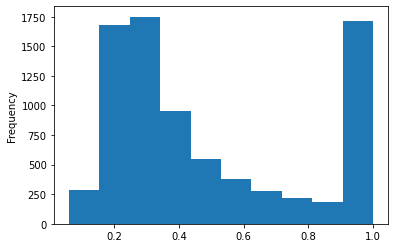

In [44]:
sub['target'].plot.hist()

In [ ]:
!ls

In [34]:
fns = list(Path('EXP_200_BASELINE_CASHE_V6').glob("*.pth"))
fns = ["EXP_200_BASELINE_CASHE_V6/EXP_200_BASELINE_CASHE_V6_convmixer_1536_20_0_13.pth", 
      ]

In [45]:
#predict train

for mw in fns:
    print('_______')
    print(mw)
    df_eval = pd.read_csv('../../val/val.csv')
    df_eval.id = df_eval.id.apply(lambda x: Path(f"../../val/v18val/{x}.pickle"))
    df_eval.columns = ['id', 'base_id', 'snr', 'target', 'f0', 'F1', 'F2', 'Alpha',
           'Delta', 'cosi', 'psi', 'phi', 'path', 'freq', 'nonstationary',
           'artifact']
    sub_ds = ValLoaderPickle(df_eval)
    vld_dl = DataLoader(
        sub_ds,
        batch_size=CFG.bs,
        shuffle=False,
        num_workers=CFG.nw,
        pin_memory=True,
        drop_last=False
    )

    custom_model = create_model(
                        CFG.model_name,
                        pretrained=True,
                        num_classes=1,
                        in_chans=2,
                    )

    custom_model.load_state_dict(torch.load(mw))
    custom_model.cuda();
    custom_model.eval();

    res = predict_tta(vld_dl, custom_model)
    df_eval['pred'] = torch.cat(res).view(-1).numpy()
    break
    df_eval['snr'] = df_eval['snr'].replace(1000, 0)
    df_eval = df_eval.dropna(subset='pred')
    dict_res = generate_report(df_eval)
    dict_res_400_500 = generate_report(df_eval.query('freq>400 and freq<500'))
    dict_res_300_400 = generate_report(df_eval.query('freq>300 and freq<400'))
    dict_res_200_300 = generate_report(df_eval.query('freq>200 and freq<300'))
    dict_res_50_200 = generate_report(df_eval.query('freq>50 and freq<200'))
    print('___all___')
    print(dict_res)
    print('freq_400_500:')
    print(dict_res_400_500)
    print('freq_300_400:')
    print(dict_res_300_400)
    print('freq_200_300:')
    print(dict_res_200_300)
    print('freq_50_200:')
    print(dict_res_50_200)



_______
EXP_200_BASELINE_CASHE_V6/EXP_200_BASELINE_CASHE_V6_convmixer_1536_20_0_13.pth


  7%|█████▊                                                                           | 18/250 [00:19<03:43,  1.04it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 10%|████████▍                                                                        | 26/250 [00:27<03:36,  1.03it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
 23%|██████████████████▍                                                              | 57/250 [00:57<03:10,  1.01it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 42%|█████████████████████████████████▎                                              | 104/250 [01:44<02:25,  1.01it/s]/opt/conda/

In [46]:
df_eval.id = df_eval.id.apply(lambda x: x.stem)
df_eval.to_csv('EXP_200_BASELINE_CASHE_V6_MIXER_EVAL_CORRECT.csv', index=False)

In [ ]:
0.724
0.7242

#0.7251

In [51]:
roc_auc_score(df_eval.dropna(subset='pred')['target'], df_eval.dropna(subset='pred')['pred'])

0.7111302727653694

In [33]:
def nonlinearity(x):
    # swish
    return x * torch.sigmoid(x)


class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout,
        temb_channels=512,
    ):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels, out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(
                    in_channels, out_channels, kernel_size=3, stride=1, padding=1
                )
            else:
                self.nin_shortcut = torch.nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=1, padding=0
                )

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x + h


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(
        num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True
    )


class Encoder(nn.Module):
    def __init__(
        self,
        *,
        ch,
        ch_mult=(1, 2,),
        num_res_blocks,
        attn_resolutions,
        dropout=0.0,
        resamp_with_conv=True,
        in_channels,
        resolution,
        z_channels,
        double_z=True,
        embed_in = 0,
        use_linear_attn=False,
        attn_type="linear",
        **ignore_kwargs,
    ):
        super().__init__()
        if use_linear_attn:
            attn_type = "linear"
        self.ch = ch
        self.temb_ch = embed_in
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(
            in_channels, self.ch, kernel_size=(12, 12), stride=1, padding=1
        )

        curr_res = resolution
        in_ch_mult = (1,) + tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch * in_ch_mult[i_level]
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(
                    ResnetBlock(
                        in_channels=block_in,
                        out_channels=block_out,
                        temb_channels=self.temb_ch,
                        dropout=dropout,
                    )
                )
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions - 1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(
            in_channels=block_in,
            out_channels=block_in,
            temb_channels=self.temb_ch,
            dropout=dropout,
        )
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(
            in_channels=block_in,
            out_channels=block_in,
            temb_channels=self.temb_ch,
            dropout=dropout,
        )

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(
            block_in,
            2 * z_channels if double_z else z_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x, temb=None):
        # timestep embedding
        temb = temb

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions - 1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=2, padding=0
            )

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f"attn_type {attn_type} unknown"
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(
            qkv, "b (qkv heads c) h w -> qkv b heads c (h w)", heads=self.heads, qkv=3
        )
        k = k.softmax(dim=-1)
        context = torch.einsum("bhdn,bhen->bhde", k, v)
        out = torch.einsum("bhde,bhdn->bhen", context, q)
        out = rearrange(
            out, "b heads c (h w) -> b (heads c) h w", heads=self.heads, h=h, w=w
        )
        return self.to_out(out)


from einops import rearrange, repeat


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.k = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.v = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.proj_out = torch.nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape
        q = q.reshape(b, c, h * w)
        q = q.permute(0, 2, 1)  # b,hw,c
        k = k.reshape(b, c, h * w)  # b,c,hw
        w_ = torch.bmm(q, k)  # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c) ** (-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h * w)
        w_ = w_.permute(0, 2, 1)  # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v, w_)  # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b, c, h, w)

        h_ = self.proj_out(h_)

        return x + h_


class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""

    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)

In [34]:
Encoder(
    ch=32,
    num_res_blocks=3,
    attn_resolutions=[],
    in_channels=2,
    resolution=256,
    z_channels=3,
    double_z=False,
    embed_in=412,
)(torch.rand(1, 2, 360, 144), torch.rand(1, 412)).shape

making attention of type 'linear' with 64 in_channels


torch.Size([1, 3, 175, 67])

In [35]:
Encoder(
    ch=32,
    num_res_blocks=3,
    attn_resolutions=[],
    in_channels=2,
    resolution=256,
    z_channels=3,
    double_z=False,
    embed_in=412,
)

making attention of type 'linear' with 64 in_channels


Encoder(
  (conv_in): Conv2d(2, 32, kernel_size=(12, 12), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=412, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=412, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32